# Chronos Vignette

This vignette walks through a simple exercise in training Chronos on a subset of DepMap public 20Q4 data. 
Notes:
I had tp install a special version of tesorflow
I found in here, otherwise it did not run, it is some sort of incompatibility between MAC and tensorflow

https://drive.google.com/drive/folders/1oSipZLnoeQB0Awz8U68KYeCPsULy_dQ7

## Imports

In [13]:
import numpy as np
import pandas as pd
import chronos
import os
from matplotlib import pyplot as plt
import seaborn as sns

## Setting up the Data

Chronos always requires at least three dataframes: 
* a matrix of readcounts with sequenced entities as the index, individual sgRNAs as the columns, and values indicating how many reads were found for that sgRNA. A sequenced entity any vector of sgRNA readcounts read out during the experiment. It could be a sequencing run of pDNA, or of a biological replicate at some time point during the experiment.
* A sequence map mapping sequenced entities to either pDNA or a cell line and giving the days since infection and pDNA batch. 
* A guide map mapping sgRNAs to genes. Each sgRNA included must map to one and only one gene.

In [14]:
sequence_map = pd.read_csv("Data/Achilles_sequence_map.csv")
guide_map = pd.read_csv("Data/avana_guide_map.csv")
readcounts = pd.read_csv("Data/Achilles_readcounts.csv", index_col=0)

Sequence maps must have the columns

* sequence_id (str), which must match a row in readcounts
* cell_line_name (str). Must be "pDNA" for pDNA, and each pDNA batch must have at least one pDNA measurement.
* pDNA batch (any simple hashable type, preferably int or str). pDNA measurements sharing the same batch will be grouped and averaged, then used as the reference for all biological replicate sequencings assigned that same batch. If you don't have multiple pDNA batches (by far the most common experimental condition), just fill this column with 0 or some other constant value.
* days: days post infection. This value will be ignored for pDNA.

Other columns will be ignored.

Guide maps must have the columns 

* sgrna (str): must match a column in readcounts. An sgrna can only appear once in this data frame.
* gene (str): the gene the sgrna maps to.

Other columns will be ignored.

In [17]:
guide_map[:4]

,sgrna,genome_alignment,gene,n_alignments,positive_control,negative_control
0,AAAAAAATCCAGCAATGCAG,chr10_110964620_+,SHOC2 (8036),1,True,False
1,AAAAAAGAAGAAAAAACCAG,chr4_75970356_-,SDAD1 (55153),1,True,False
2,AAAAACTCTGGGAAATGACT,chr1_229305137_+,SPHAR (10638),1,False,True
3,AAAAAGATCATGATTGAGCG,chr12_123630253_-,EIF2B1 (1967),1,True,False


Finally, here's what readcounts should look like. They can include NaNs. Note the axes.

In [18]:
readcounts.iloc[:4, :3]

,AAAAAAATCCAGCAATGCAG,AAAAAAGAAGAAAAAACCAG,AAAAACTCTGGGAAATGACT
SNU-840 311Cas9_RepC_p6_batch2,348.0,78.0,430.0
A549-311Cas9 Rep A p5_batch3,257.0,100.0,398.0
SNU-840 311Cas9_RepA_p6_batch2,531.0,160.0,358.0
COLO320-311Cas9 Rep B p6_batch3,441.0,154.0,608.0


### NaNing clonal outgrowths

In Achilles, we've observed rare instances where a single guide in a single biological replicate will produce an unexpectedly large number of readcounts, while other guides targeting the same gene or other replicates of the same cell line do not show many readcounts. We suspect this is the result of a single clone gaining some fitness advantage. Although it _could_ be related to a change induced by the guide, in general it's probably misleading. Therefore Chronos has an option to identify and remove these events.

In [19]:
chronos.nan_outgrowths(readcounts=readcounts, guide_gene_map=guide_map,
                                   sequence_map=sequence_map)

calculating LFC
finding maximum LFC cells
finding sequences and guides with outgrowth
22 (0.00442% of) readcounts to be removed
                                    gene              
SNU-840 311Cas9_RepC_p6_batch2      PTEN (5728)           2.331286
A549-311Cas9 Rep A p5_batch3        OR2G2 (81470)         2.223027
                                    PSPC1 (55269)         2.356427
                                    PTEN (5728)           3.103739
                                    TNFRSF13C (115650)    2.500551
                                    TRABD2B (388630)      2.215409
Panc.02.03-311cas9 Rep C p6_batch3  VIPR2 (7434)          2.276700
SNU-840 311Cas9_RepB_p6_batch2      PTEN (5728)           2.435050
A549-311Cas9 Rep D p5_batch3        FIBP (9158)           2.795995
                                    PTEN (5728)           2.372597
dtype: float64
NaNing bad outgrowths


/Users/ireneroblesrebollo/Library/CloudStorage/OneDrive-CoSyneTherapeutics/Code/Chronos/chronos/model.py:227: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  problems = pd.Series()


### Train Chronos

Now we initialize the model. Note the form of the data: each of the three parameters is actually a dictionary. If we were training the model with data from multiple libraries simultaneously, each library's data would have its own entries in the dict.

In [21]:
model = chronos.Chronos(
    sequence_map={"avana": sequence_map},
    guide_gene_map={"avana": guide_map},
    readcounts={"avana": readcounts}
)



Finding all unique guides and genes
found 17785 unique guides and 4712 unique genes in avana
found 17785 unique guides and 4712 unique genes overall

finding guide-gene mapping indices

finding all unique sequenced replicates, cell lines, and pDNA batches
found 20 unique sequences (excluding pDNA) and 7 unique cell lines in avana
found 20 unique replicates and 7 unique cell lines overall

finding replicate-cell line mappings indices

finding replicate-pDNA mappings indices


assigning float constants
initializing graph

building gene effect mask
built mask with no exclusions

building doubling vectors
made days vector of shape [20, 1] for avana

building late observed timepoints
	built normalized timepoints for avana with shape (20, 17785) (replicates X guides)

building initial reads


Building variables

building initial reads estimate
made initial batch with shape (2, 17785) for avana
building guide efficacy
built guide efficacy: shape [1, 17786]
building growth rate
built growth 

Now, optimizing the model:

In [22]:
model.train(801)

cost 0.6697998521139488
relative_growth_rate
	avana max 1.022, min 0.98592, mean 1.000
mean guide efficacy 0.9920501590325331
initial_offset SD: [('avana', 0.0)]

gene mean -2.952882586702095e-08
SD of gene means 7.348462410632376e-06
Mean of gene SDs 7.567008702123128e-06



51 epochs trained, time taken 0:00:01, projected remaining 0:00:15
cost 0.424728436088177
relative_growth_rate
	avana max 1.022, min 0.98592, mean 1.000
mean guide efficacy 0.9920501590325331
initial_offset SD: [('avana', 0.0)]

gene mean 0.004138878271623016
SD of gene means 0.011323228955437909
Mean of gene SDs 0.010600487285289381



101 epochs trained, time taken 0:00:02, projected remaining 0:00:14
cost 0.2867407124899476
relative_growth_rate
	avana max 1.059, min 0.96804, mean 1.000
mean guide efficacy 0.9837464813420377
initial_offset SD: [('avana', 0.019075153069308272)]

gene mean 0.011440043620674962
SD of gene means 0.026093187558526756
Mean of gene SDs 0.013211784884449884



151 epochs trained, time t

## Scaling

We can get back the model for gene effects as follows:

In [23]:
gene_effects = model.gene_effect

gene_effects.iloc[:4, :5]

,A1CF (29974),AAED1 (195827),AAMDC (28971),AAMP (14),AARS (16)
ACH-000042,0.032967,0.028481,0.038190,-0.020291,-0.088090
ACH-000202,0.018409,0.025211,0.038294,-0.031794,-0.111022
ACH-000280,0.042798,0.014285,0.024179,-0.019158,-0.108154
ACH-000552,0.038241,0.023143,0.032034,-0.023616,-0.114715


The gene effects represent Chronos' estimate of the relative change in growth rate for a cell line, but the scale is unintuitive. We'll use the normal Achilles convention, where -1 is the median of essential gene effects and 0 is the median of nonessential gene effects. Note that we are just scaling the data overall--not per cell line, as DepMap does with CERES scores.

In [28]:

nonessentials = guide_map.query("negative_control").gene
essentials = guide_map.query("positive_control").gene
gene_effects -= gene_effects[nonessentials].median().median()
gene_effects /= np.abs(gene_effects[essentials].median().median())

gene_effects.iloc[:4, :5]

,A1CF (29974),AAED1 (195827),AAMDC (28971),AAMP (14),AARS (16)
ACH-000042,0.028022,-0.026196,0.091145,-0.615628,-1.435023
ACH-000202,-0.147917,-0.065716,0.092403,-0.754658,-1.712168
ACH-000280,0.146841,-0.197764,-0.078182,-0.601938,-1.677505
ACH-000552,0.091767,-0.090712,0.016753,-0.655822,-1.756807


Here's what the distribution of scores for the two control groups looks like over all cell lines.

Text(0.5, 0, 'Chronos Gene Effect Scores')

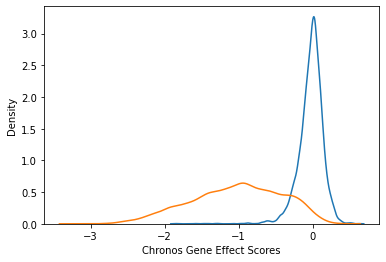

In [34]:
sns.kdeplot(gene_effects[nonessentials].stack().tolist(), label="Nonessentials",
           gridsize=1000)
sns.kdeplot(gene_effects[essentials].stack().tolist(), label="Essentials",
           gridsize=1000)
plt.xlabel("Chronos Gene Effect Scores")

## Copy Number Correction

If you have gene-level copy number calls, Chronos includes an option to correct gene effect scores after the fact. This works best if the data has been scaled, as above.

In [35]:
cn = pd.read_csv("Data/CCLE_copy_number.csv", index_col=0)
cn.iloc[:4, :3]

,SHOC2 (8036),SDAD1 (55153),SPHAR (10638)
ACH-000202,0.913049,0.958755,0.921488
ACH-000552,1.104365,0.000000,1.144815
ACH-000681,1.199605,0.875817,0.000000
ACH-000866,1.049551,0.000000,1.640867


Unfortunately, we don't have copy number calls for some of the genes targeted by the Avana library:

In [38]:
try:
    corrected, shifts = chronos.alternate_CN(gene_effects, cn)
except ValueError as e:
    print(e)


Fitting cell line group 1 of 1
finding low CN gene effect shifts
smoothing and interpolating cutting toxicity for all genes
constructed spline matrix of shape 32984, 105
	cost: 0.028147924751561533
	cost: 0.027703685409387526
	cost: 0.027688848654526758
	cost: 0.027684429886824763
	cost: 0.027681921900067376
	cost: 0.027680099097028957
generating matrix


We could choose to drop these genes. Instead, we'll assume normal ploidy (=1, in the current CCLE convention) for them and fill in the CN matrix accordingly.

In [39]:
for col in set(gene_effects.columns) - set(cn.columns):
    cn[col] = 1

In [40]:
corrected, shifts = chronos.alternate_CN(gene_effects, cn)


Fitting cell line group 1 of 1
finding low CN gene effect shifts
smoothing and interpolating cutting toxicity for all genes
constructed spline matrix of shape 32984, 105
	cost: 0.028147527261379094
	cost: 0.027703656569804305
	cost: 0.02768882460816209
	cost: 0.027684422736686084
	cost: 0.027681899636540077
	cost: 0.027680081598830515
generating matrix


The "shifts" dataframe contains some information about the inferred CN effect, while corrected contains the corrected gene effects matrix. Overall, gene effect matrices will change little after correction, since most genes in most lines are near diploid.

Text(0.5, 0, 'Chronos Gene Effect Scores')

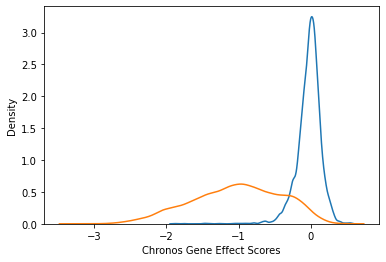

In [42]:
sns.kdeplot(corrected[nonessentials].stack().tolist(), label="Nonessentials",
           gridsize=1000)
sns.kdeplot(corrected[essentials].stack().tolist(), label="Essentials",
           gridsize=1000)
plt.xlabel("Chronos Gene Effect Scores")

In [46]:
!conda list

# packages in environment at /Users/ireneroblesrebollo/opt/anaconda3/envs/chronos_env:
#
# Name                    Version                   Build  Channel
absl-py                   0.15.0                   pypi_0    pypi
anyio                     3.5.0            py38hecd8cb5_0  
appnope                   0.1.2           py38hecd8cb5_1001  
argon2-cffi               21.3.0             pyhd3eb1b0_0  
argon2-cffi-bindings      21.2.0           py38hca72f7f_0  
asttokens                 2.0.5              pyhd3eb1b0_0  
astunparse                1.6.3                    pypi_0    pypi
attrs                     21.4.0             pyhd3eb1b0_0  
babel                     2.9.1              pyhd3eb1b0_0  
backcall                  0.2.0              pyhd3eb1b0_0  
beautifulsoup4            4.11.1           py38hecd8cb5_0  
blas                      1.0                         mkl  
bleach                    4.1.0              pyhd3eb1b0_0  
bottleneck                1.3.5            py38h67